In [9]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


## Daten definieren und vorbereiten

In [10]:
# 1. Daten laden
df_cars = pd.read_csv("used_cars_with_country.csv")
df_country = pd.read_csv("country_data.csv")

# Preis-Spalte bereinigen ('10,300' -> 10300.0)
df_cars["price"] = df_cars["price"].astype(str).str.replace(r"[^\d.]", "", regex=True).astype(float)

# Milage-Spalte bereinigen ('73,049 mi.' -> 73049.0)
df_cars["milage"] = df_cars["milage"].astype(str).str.replace(r"[^\d.]", "", regex=True).astype(float)

# Engine-, Farbangaben und textuelle Spalten entfernen, die nicht numerisch oder dummyfähig sind
drop_cols = ["engine", "ext_col", "int_col", "accident", "clean_title"]
for col in drop_cols:
    if col in df_cars.columns:
        df_cars.drop(columns=[col], inplace=True)

# 2. Daten mergen
merged_df = pd.merge(df_cars, df_country, on="country", how="left")

# Konvertiere numerische Spalten
for col in ["price", "income", "gdpp"]:
    merged_df[col] = pd.to_numeric(merged_df[col], errors="coerce")

# 3. Feature Engineering
merged_df["relative_price"] = merged_df["price"] / merged_df["income"]
merged_df["price_vs_gdpp"] = merged_df["price"] / merged_df["gdpp"]

# Modellnamen als Kategorie encodieren
if "model" in merged_df.columns:
    merged_df["model"] = merged_df["model"].astype(str)
    merged_df = pd.get_dummies(merged_df, columns=["model"], drop_first=True)

# 4. Preprocessing: Kategorische Variablen encodieren
merged_df = pd.get_dummies(merged_df, columns=["brand", "fuel_type", "transmission", "country"], drop_first=True)

## Features und Zielvariable definieren

In [11]:
y = merged_df["price"]
X = merged_df.drop(columns=["price", "relative_price"])
X = X.select_dtypes(include=[np.number])


## Train/Test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
merged_df = merged_df[(merged_df["price"] > 500) & (merged_df["price"] < 100000)]


## Model trainieren

In [14]:
from sklearn.impute import SimpleImputer

# Impute missing values in features
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train_imputed, y_train)
pred_lr = model_lr.predict(X_test_imputed)

# Random Forest
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train_imputed, y_train)
pred_rf = model_rf.predict(X_test_imputed)


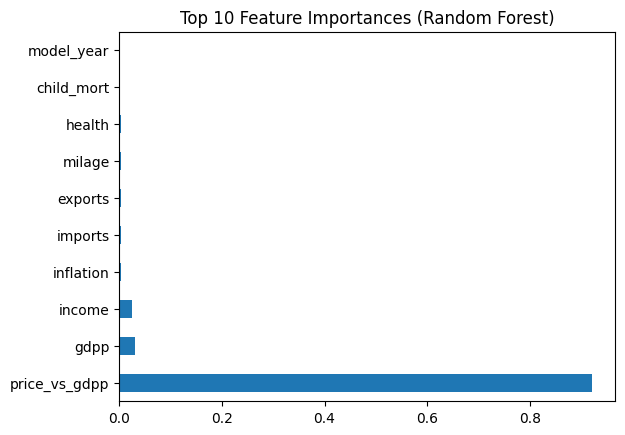

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

## Modelle evaluieren

In [16]:
def evaluate(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> RMSE: {rmse:.2f}, R^2: {r2:.2f}")

evaluate("Linear Regression", y_test, pred_lr)
evaluate("Random Forest", y_test, pred_rf)

# 9. Bestes Modell speichern (z. B. Random Forest)
with open("model.pkl", "wb") as f:
    pickle.dump((model_rf, X.columns), f)

print("Modell gespeichert unter model.pkl")

Linear Regression -> RMSE: 28375.74, R^2: 0.96
Random Forest -> RMSE: 99481.67, R^2: 0.52
Modell gespeichert unter model.pkl
